# Linguistic Laws Meet Protein Sequences: A Comparative Analysis of Subword Tokenization Methods

In [2]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import linregress

In [3]:
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Data

In [4]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)


In [5]:
uniref_id = "50"
df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000]
df_protein

,uniprot_id,sequence
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
2,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...
3,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
4,A0A0C5B5G6,MRWQEMGYIFYPRKLR
...,...,...
70896,X6RL83,MLQEWLAAVGDDYAAVVWRPEGEPRFYPDEEGPKHWTKERHQFLME...
70897,X6RLN4,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...
70898,X6RLR1,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...
70899,X6RLV5,MSGYSSDRDRGRDRGFGAPRFGGSRAGPLSGKKFGNPGEKLVKKKW...


In [6]:
conn.close()

## Load Tokenizers

In [7]:
methods_opts = {
    'mutbpe_7_0':
    {
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0,
        'min_mutation_len': 3,
        'max_mutation_len': 12
    },
    'mutbpe_8_0':
    {
        'mutation_cutoff': 0.8,
        'min_mutation_freq': 0,
        'min_mutation_len': 3,
        'max_mutation_len': 12
    },
    'mutbpe_7_05':
    {
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12
    }
}

In [8]:
methods = ['bpe', 'mutbpe_7_0', 'mutbpe_8_0', 'mutbpe_7_05']
methods2names = {'bpe':'Standard BPE', 'mutbpe_7_0':'mutBPE 0.7 0', 'mutbpe_8_0':'mutBPE 0.8 0', 'mutbpe_7_05':'mutBPE 0.7 0.05'}
vocab_sizes = [800, 1600, 3200, 6400, 12800]

In [9]:
tokenizer_folder_name = '/cta/share/users/mutbpe/tokenizers/blosum62'

tokenizer_list = {}
for vocab_size in vocab_sizes:
    file_name = f"hf_uniref{uniref_id}_bpe_{vocab_size}"
    tokenizer_list[f"{methods[0]}_{vocab_size}"] = Tokenizer.from_file(f"{tokenizer_folder_name}/{file_name}.json")

for method in methods[1:]:
    for vocab_size in vocab_sizes:
        opts = methods_opts[method]
        file_name = f"hf_uniref{uniref_id}_mutbpe_{opts['mutation_cutoff']}_{opts['min_mutation_len']}_{opts['max_mutation_len']}_{opts['min_mutation_freq']}_{vocab_size}"
        tokenizer_list[f"{method}_{vocab_size}"] = Tokenizer.from_file(f"{tokenizer_folder_name}/{file_name}.json")

In [10]:
vocab_list = {}
for name, tokenizer in tokenizer_list.items():
    vocab_list[name] = list(set([token for token, idx in tokenizer.get_vocab().items()]))

## Apply Tokenizers to Data

In [11]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


## Configs for the plots

In [12]:
sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred']
markers = ["o--", "d--", "*--", "X--", "P--", "p--"]
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

## Shared Token Percentages

Shared token percentages offer insight into segmentation consistency.

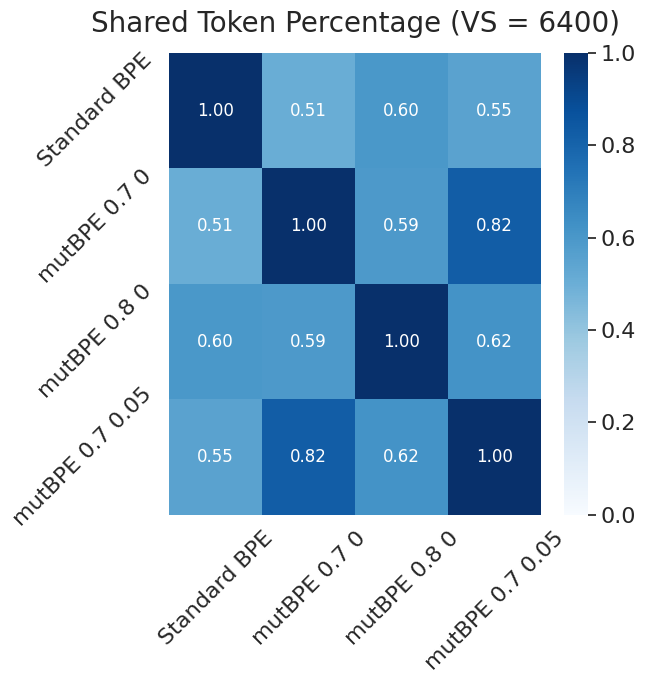

In [15]:
vocab_size = 6400
comp_tokenizers_list =  [f"{method}_{vocab_size}" for method in methods]
comp_labels = list(methods2names.values())

data = np.array(np.zeros((len(methods),len(methods))))
for i in range(len(comp_tokenizers_list)):
    for j in range(i, len(comp_tokenizers_list)):
        data[i][j] = len(set(vocab_list[comp_tokenizers_list[i]]).intersection(set(vocab_list[comp_tokenizers_list[j]])))
        data[i][j] /= min(len(vocab_list[comp_tokenizers_list[i]]), len(vocab_list[comp_tokenizers_list[j]]))
        data[j][i] = data[i][j]
# data = data.astype(int)

fig,ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)

sns.heatmap(data, annot = True, fmt='.2f', xticklabels=comp_labels, yticklabels=comp_labels, vmax=1, vmin=0, cmap='Blues')
plt.yticks(rotation=45)
plt.xticks(rotation=45)

plt.title(f"Shared Token Percentage (VS = {vocab_size})", pad=title_pad)

# plt.savefig(f'{figures_folder_name}/shared_token_percent_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/shared_token_percent_{vocab_size}.png', bbox_inches='tight')
plt.show()

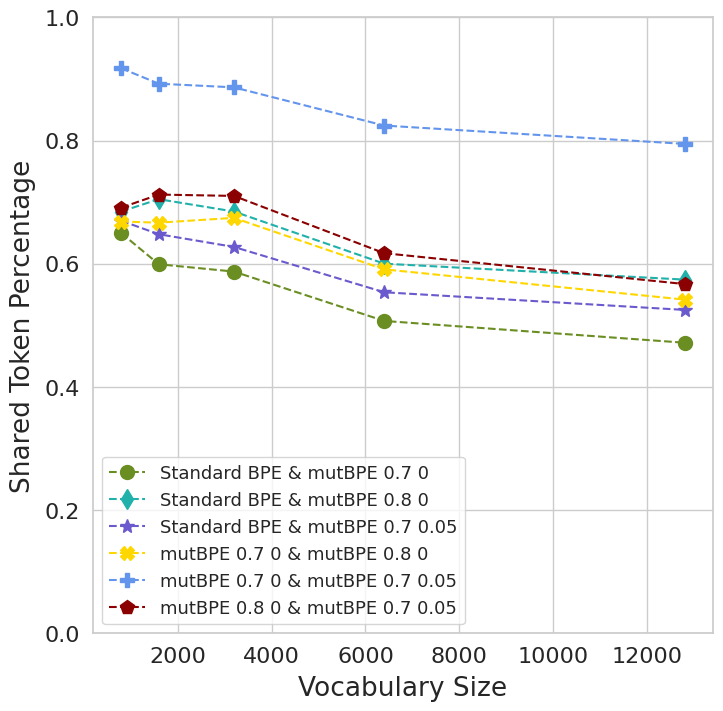

In [16]:
sns.set_style("whitegrid")
for i, (method1, method2) in enumerate([(m1, m2) for j, m1 in enumerate(methods) for _, m2 in enumerate(methods[j+1:])]):
    shared_token_percs = []
    for vocab_size in vocab_sizes:
        tokenizer1 = f'{method1}_{vocab_size}'
        tokenizer2 = f'{method2}_{vocab_size}'
        shared_token_percs.append(len(set(vocab_list[tokenizer1]).intersection(set(vocab_list[tokenizer2]))))
        shared_token_percs[-1] /= min(len(vocab_list[tokenizer1]), len(vocab_list[tokenizer2]))
    plt.plot(vocab_sizes, shared_token_percs, markers[i], color=colors[i], markersize=10, label=f'{methods2names[method1]} & {methods2names[method2]}')


# plt.title(f"Shared Token Percentage Change of Vocab Sizes Between BPE and WordPiece", pad=title_pad, size=13)
plt.legend()
plt.ylim(top=1, bottom=0)
plt.xticks()
plt.yticks()
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Shared Token Percentage", labelpad=label_pad);
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.png', bbox_inches='tight')
plt.show()

## Token Length Distribution

Token length distribution reflects the granularity of the segmentation.

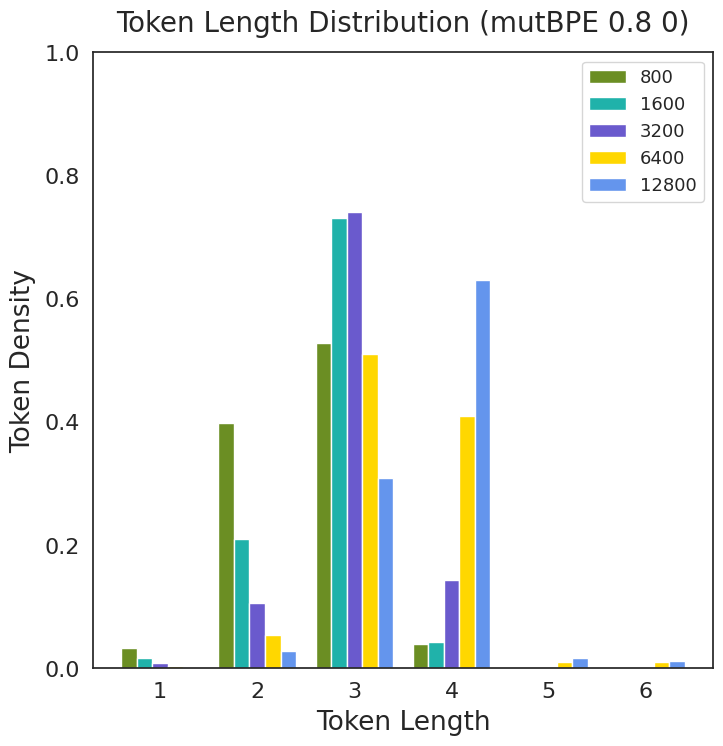

In [17]:
sns.set_style("white")

method = methods[2]
comp_tokenizers_list = [f"{method}_{vocab_size}" for vocab_size in vocab_sizes]

a = plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5,6.5], histtype='bar', label=vocab_sizes, density=True, color=colors[:len(vocab_sizes)])

plt.title(f"Token Length Distribution ({methods2names[method]})", pad=title_pad)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
# plt.savefig(f'{figures_folder_name}/token_length_dist_{method}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_dist_{method}.png', bbox_inches='tight')
plt.show()

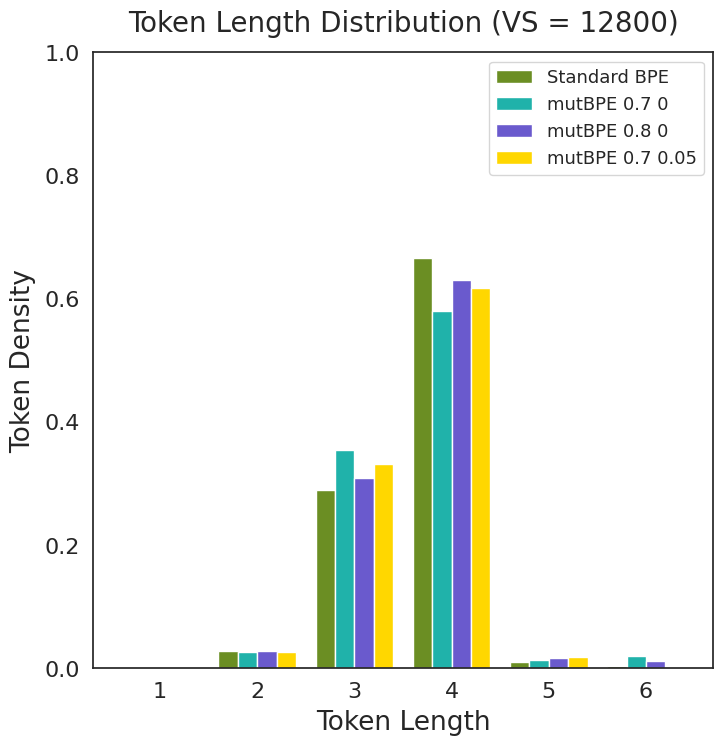

In [18]:
sns.set_style("white")

vocab_size = vocab_sizes[4]
comp_tokenizers_list = [f"{method}_{vocab_size}" for method in methods]
comp_labels_list = [methods2names[method] for method in methods]

plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5,6.5], histtype='bar', label=comp_labels_list, density=True, color=colors[:len(methods)])

plt.title(f"Token Length Distribution (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
# plt.savefig(f'{figures_folder_name}/token_length_dist_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_dist_{vocab_size}.png', bbox_inches='tight')
plt.show()

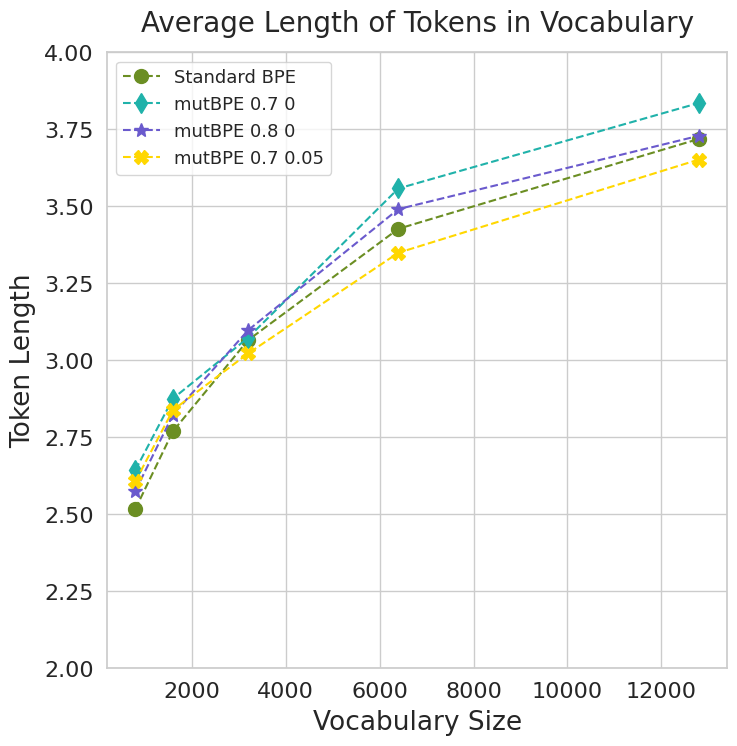

In [19]:
sns.set_style("whitegrid")
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [np.mean([len(token) for token in vocab_list[f'{method}_{vocab_size}']]) for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Average Length of Tokens in Vocabulary", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Length", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
plt.ylim([2.0, 4])

# plt.savefig(f'{figures_folder_name}/token_length_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_plot.png', bbox_inches='tight')

plt.show()

In [20]:
{name: np.mean([len(token) for token in vocab]) for name, vocab in vocab_list.items()}

{'bpe_800': np.float64(2.5175),
 'bpe_1600': np.float64(2.77),
 'bpe_3200': np.float64(3.0659375),
 'bpe_6400': np.float64(3.4275),
 'bpe_12800': np.float64(3.719453125),
 'mutbpe_7_0_800': np.float64(2.64375),
 'mutbpe_7_0_1600': np.float64(2.87625),
 'mutbpe_7_0_3200': np.float64(3.07375),
 'mutbpe_7_0_6400': np.float64(3.5584375),
 'mutbpe_7_0_12800': np.float64(3.836015625),
 'mutbpe_8_0_800': np.float64(2.57625),
 'mutbpe_8_0_1600': np.float64(2.82375),
 'mutbpe_8_0_3200': np.float64(3.098125),
 'mutbpe_8_0_6400': np.float64(3.49140625),
 'mutbpe_8_0_12800': np.float64(3.729609375),
 'mutbpe_7_05_800': np.float64(2.6075),
 'mutbpe_7_05_1600': np.float64(2.83875),
 'mutbpe_7_05_3200': np.float64(3.0228125),
 'mutbpe_7_05_6400': np.float64(3.3496875),
 'mutbpe_7_05_12800': np.float64(3.652421875)}

In [21]:
test_average_token_lenghts = {name: np.mean(df_protein[name].apply(lambda xx: np.mean([len(x) for x in xx]))) for name in list(vocab_list.keys())}

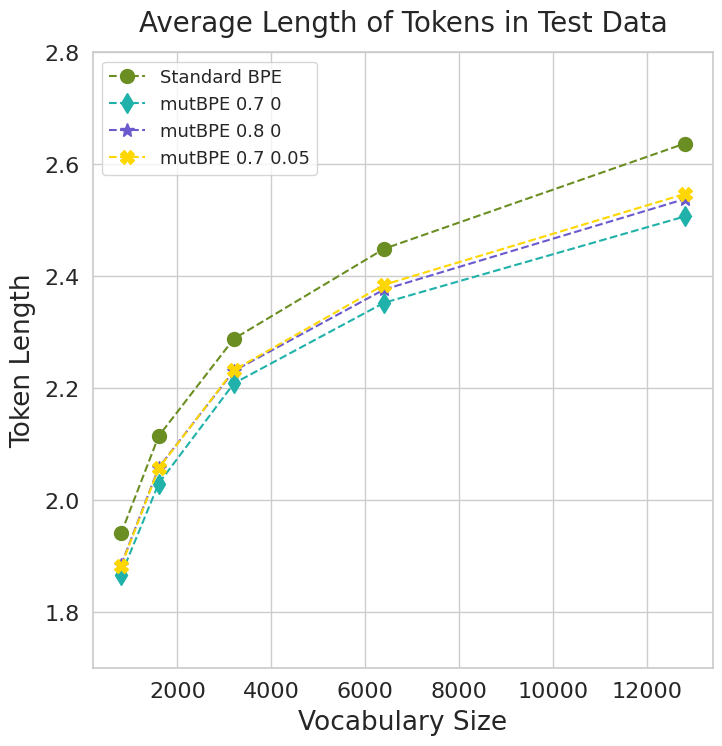

In [22]:
sns.set_style("whitegrid")

for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [test_average_token_lenghts[f'{method}_{vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Average Length of Tokens in Test Data", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Length", labelpad=label_pad)
plt.legend()

plt.ylim([1.7, 2.8])

# plt.savefig(f'{figures_folder_name}/token_length_test_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_test_plot.png', bbox_inches='tight')

plt.show()

In [23]:
test_average_token_lenghts

{'bpe_800': np.float64(1.9410385469714067),
 'bpe_1600': np.float64(2.1149063287296426),
 'bpe_3200': np.float64(2.288613902017997),
 'bpe_6400': np.float64(2.449441714693857),
 'bpe_12800': np.float64(2.637337572277018),
 'mutbpe_7_0_800': np.float64(1.8670755519164157),
 'mutbpe_7_0_1600': np.float64(2.0301969786237235),
 'mutbpe_7_0_3200': np.float64(2.208980496213778),
 'mutbpe_7_0_6400': np.float64(2.353103691202534),
 'mutbpe_7_0_12800': np.float64(2.507183005615527),
 'mutbpe_8_0_800': np.float64(1.8845980401577627),
 'mutbpe_8_0_1600': np.float64(2.058660389792891),
 'mutbpe_8_0_3200': np.float64(2.2312959875768525),
 'mutbpe_8_0_6400': np.float64(2.376738510063739),
 'mutbpe_8_0_12800': np.float64(2.5382627339824158),
 'mutbpe_7_05_800': np.float64(1.882583795282954),
 'mutbpe_7_05_1600': np.float64(2.0573270893106965),
 'mutbpe_7_05_3200': np.float64(2.232690524286761),
 'mutbpe_7_05_6400': np.float64(2.385169962731466),
 'mutbpe_7_05_12800': np.float64(2.5473068077631655)}

## Fertility

Fertility, the average number of tokens required to represent a protein sequence, indicates encoding efficiency.

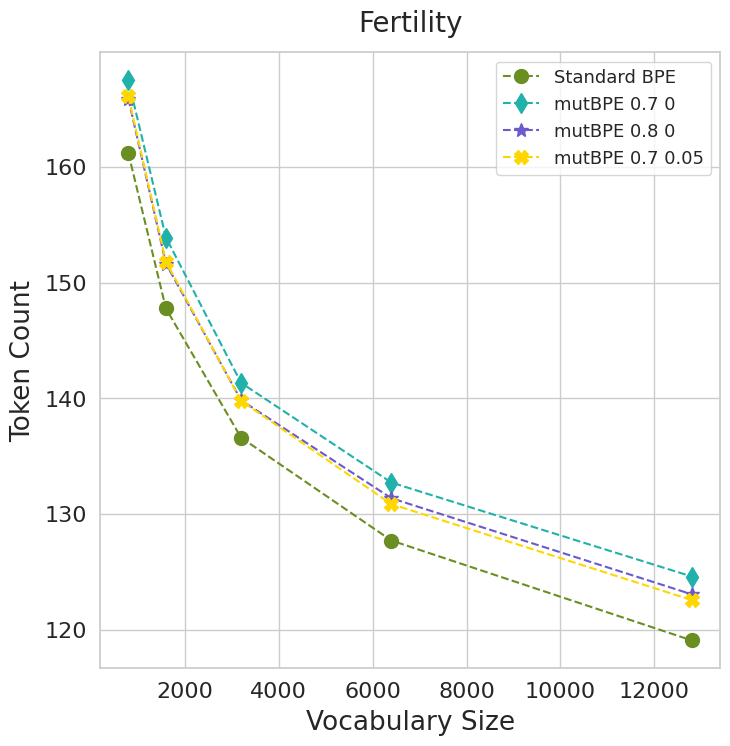

In [24]:
sns.set_style("whitegrid")
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [df_protein[f'{method}_{vocab_size}'].apply(len).mean() for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Fertility", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Count", labelpad=label_pad)
plt.legend()

# plt.savefig(f'{figures_folder_name}/fertility_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/fertility_plot.png', bbox_inches='tight')

plt.show()

## Contextual Exponence

Contextual exponence, the diversity of neighboring tokens each token encounters, sheds light on semantic relationships.

In [25]:
token_neighs = {}

window_size = 2
for name in tqdm(vocab_list.keys()):
    temp_neighs = {}
    for seq in df_protein[name]:
        for i, tok in enumerate(seq):
            if tok not in temp_neighs:
                temp_neighs[tok] = []
            temp_neighs[tok].extend(seq[max(i-window_size, 0):i])
            temp_neighs[tok].extend(seq[i+1:min(i+window_size+1, len(seq))])
    token_neighs[name] = temp_neighs
    
token_neighs_unq_len = {name: {token: len(set(neighs)) for token, neighs in tokens.items()} for name, tokens in token_neighs.items()}

100%|██████████| 20/20 [02:16<00:00,  6.85s/it]


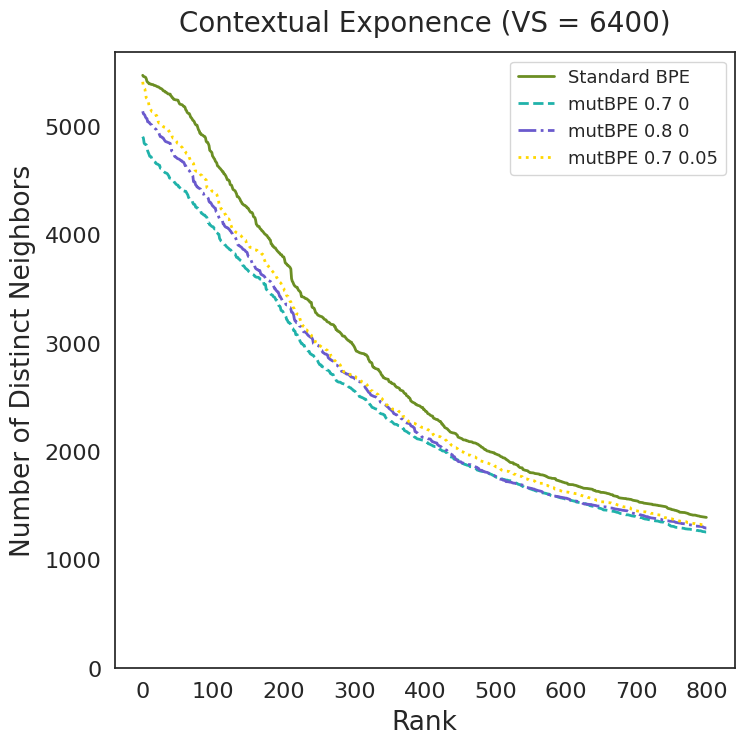

In [26]:
sns.set_style("white")
vocab_size = vocab_sizes[3]

for idx, method in enumerate(methods):
    plt.plot([t[1] for t in sorted(token_neighs_unq_len[f'{method}_{vocab_size}'].items(), key=lambda x: -x[1])[:800]], linestyles[idx], linewidth=2, color=colors[idx], label=methods2names[method])

plt.title(f"Contextual Exponence (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Rank", labelpad=label_pad)
plt.ylabel("Number of Distinct Neighbors", labelpad=label_pad)
plt.ylim(0)
# plt.xlim(right = 450)
plt.legend()

# plt.savefig(f'{figures_folder_name}/contextual_exponence_plot_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/contextual_exponence_plot_{vocab_size}.png', bbox_inches='tight')

plt.show()

## Zipf's Law

Zipf's law, the inverse proportionality between token frequency and rank, indicates linguistic regularity.

In [27]:
token_freqs_dict = {}
for tokenizer_name in tqdm(vocab_list.keys()):
    counter_series = df_protein[tokenizer_name].apply(Counter)
    counter_sum = counter_series[0]
    for cs in counter_series[1:]:
        counter_sum.update(cs)
    token_freqs_dict[tokenizer_name] = counter_sum.copy()
    # token_freqs_dict[tokenizer_name] = df_protein[tokenizer_name].apply(Counter).sum().copy()

100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


In [28]:
for tokenizer_name in tqdm(vocab_list.keys()):
    to_del = []
    for k, v in token_freqs_dict[tokenizer_name].items():
        if k not in vocab_list[tokenizer_name]:
            to_del.append(k)
    for k in to_del:
        del token_freqs_dict[tokenizer_name][k]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  5.53it/s]


In [29]:
zipf_slopes = {}
for tokenizer_name, token_freqs in token_freqs_dict.items():
    freqs = np.array(list(token_freqs.values()))
    sorted_freqs = np.sort(freqs)[::-1]
    y_data = np.log(sorted_freqs)
    x_data = np.log(np.array(range(1, len(sorted_freqs) + 1)))
    
    x_masked = x_data.copy()
    y_masked = y_data.copy()
    
    zipf_slopes[tokenizer_name] = linregress(x_masked, y_masked).slope

In [30]:
zipf_slopes

{'bpe_800': np.float64(-1.1258445380432591),
 'bpe_1600': np.float64(-1.128557593327061),
 'bpe_3200': np.float64(-1.1500369101324825),
 'bpe_6400': np.float64(-1.1783395674519657),
 'bpe_12800': np.float64(-1.1416364623496582),
 'mutbpe_7_0_800': np.float64(-1.5920632537400643),
 'mutbpe_7_0_1600': np.float64(-1.5916369714804008),
 'mutbpe_7_0_3200': np.float64(-1.5692180330631909),
 'mutbpe_7_0_6400': np.float64(-1.7512160576530238),
 'mutbpe_7_0_12800': np.float64(-1.7208274544933937),
 'mutbpe_8_0_800': np.float64(-1.4666937776184599),
 'mutbpe_8_0_1600': np.float64(-1.4062663309002357),
 'mutbpe_8_0_3200': np.float64(-1.4327013596641824),
 'mutbpe_8_0_6400': np.float64(-1.5659579122844434),
 'mutbpe_8_0_12800': np.float64(-1.5291083186252024),
 'mutbpe_7_05_800': np.float64(-1.3475996770630794),
 'mutbpe_7_05_1600': np.float64(-1.3181797337676968),
 'mutbpe_7_05_3200': np.float64(-1.319146971223346),
 'mutbpe_7_05_6400': np.float64(-1.3848206084214731),
 'mutbpe_7_05_12800': np.fl

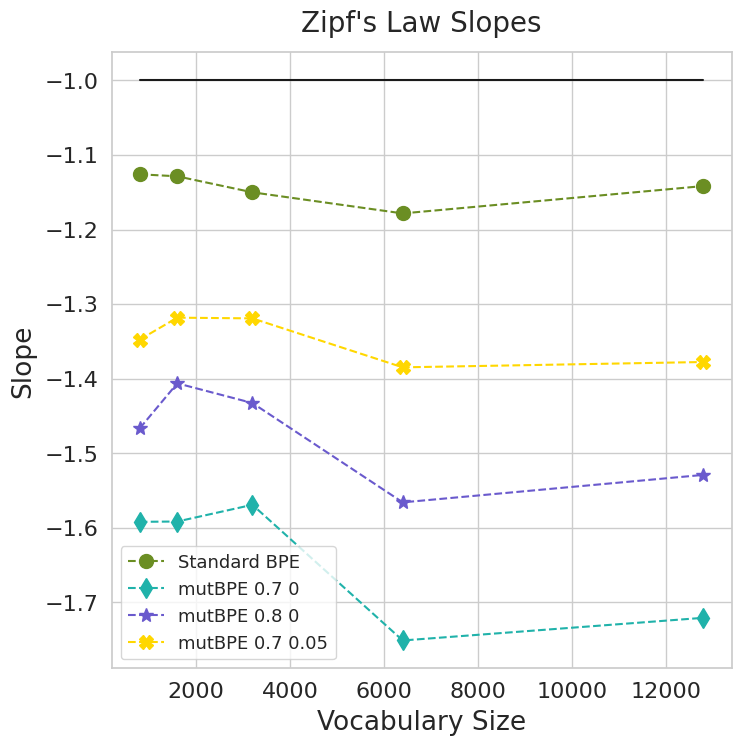

In [31]:
sns.set_style("whitegrid")

plt.plot(vocab_sizes, [-1 for _ in vocab_sizes], 'k-')

for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [zipf_slopes[f'{method}_{vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Zipf's Law Slopes", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Slope", labelpad=label_pad)
plt.legend()

# plt.savefig(f'{figures_folder_name}/zipf_slope_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/zipf_slope_plot.png', bbox_inches='tight')

plt.show()

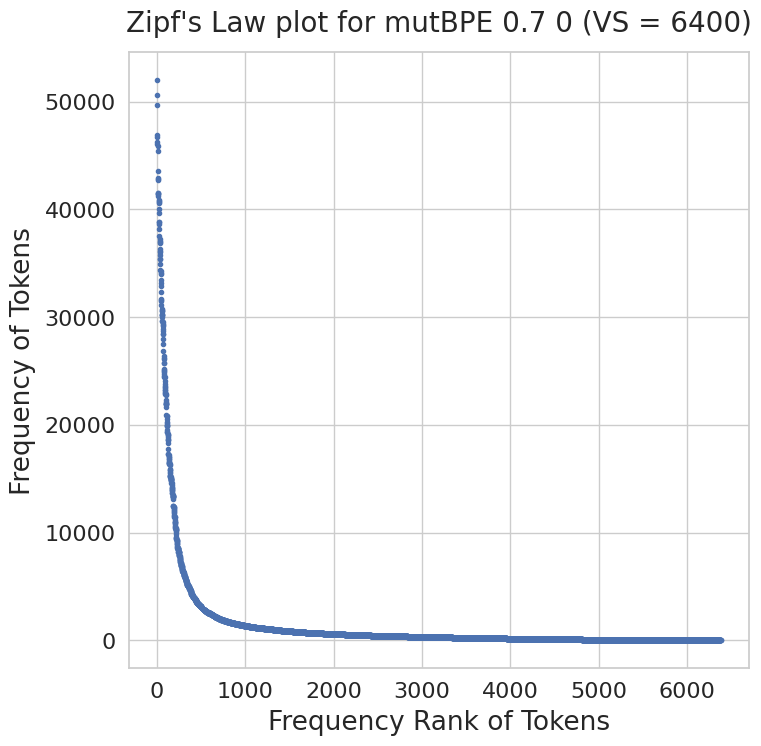

In [32]:
sns.set_style("whitegrid")
vocab_size = vocab_sizes[3]
i = 1
method = methods[i]
tokenizer_name = f'{method}_{vocab_size}'
token_freqs = token_freqs_dict[tokenizer_name]

freqs = np.array(list(token_freqs.values()))
sorted_freqs = np.sort(freqs)[::-1]

y_data = sorted_freqs
x_data = np.array(range(1, len(sorted_freqs) + 1))

plt.plot(x_data, y_data, ".")
plt.title(f"Zipf's Law plot for {methods2names[method]} (VS = {vocab_size})", pad=title_pad)
# plt.xlim([-100, 3000])
plt.xlabel("Frequency Rank of Tokens", labelpad=label_pad)
plt.ylabel("Frequency of Tokens", labelpad=label_pad)
# plt.savefig(f'{figures_folder_name}/zipf_{tokenizer_name}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/zipf_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

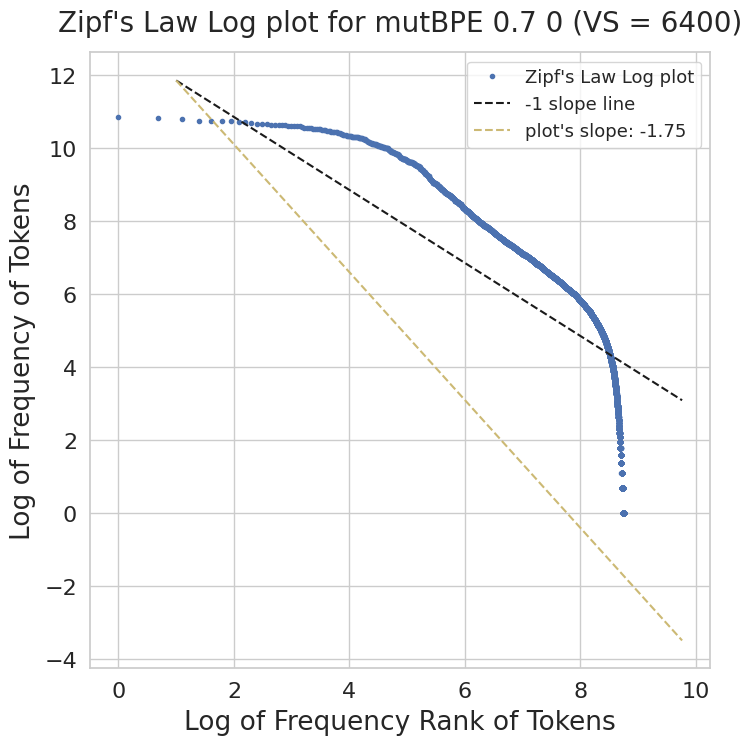

In [33]:
y_data = np.log(sorted_freqs)
x_data = np.log(np.array(range(1, len(sorted_freqs) + 1)))

x_masked = x_data.copy()
y_masked = y_data.copy()

slope = linregress(x_masked, y_masked).slope

plt.plot(x_data, y_data, ".", label="Zipf's Law Log plot")
plt.plot(x_data+1, -1*x_data+y_data[0]+1, "--", color='k', label="-1 slope line")
plt.plot(x_data+1, slope*x_data+y_data[0]-slope*x_data[0]+1, "--", color='y', label=f"plot's slope: {slope:.2f}")
plt.title(f"Zipf's Law Log plot for {methods2names[method]} (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Log of Frequency Rank of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/zipf_log_{tokenizer_name}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/zipf_log_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

## Brevity Law

Brevity law is the tendency of frequently used tokens to be shorter.

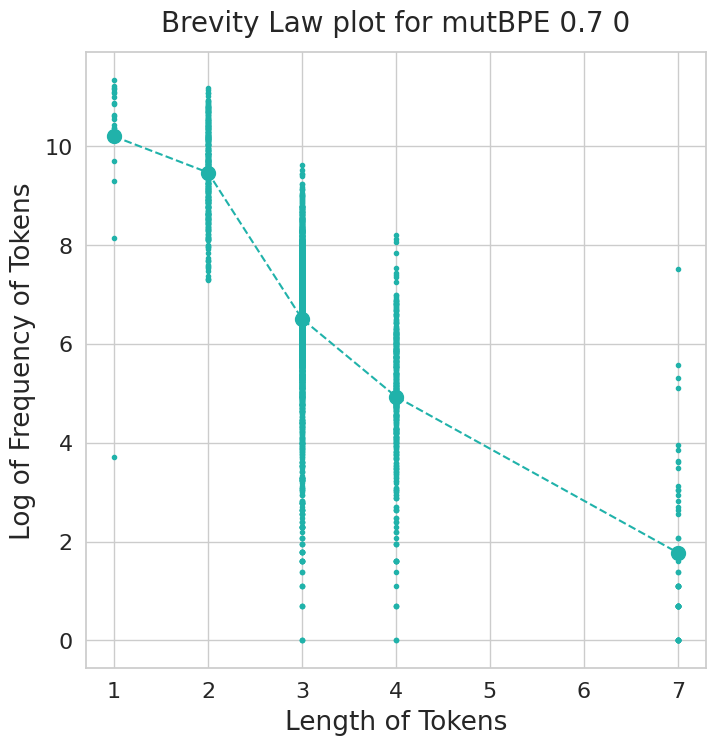

In [34]:
sns.set_style("whitegrid")
vocab_size = 3200
i = 1
method = methods[i]
tokenizer_name = f'{method}_{vocab_size}'
token_freqs = token_freqs_dict[tokenizer_name]

freqs = np.log(np.array(list(token_freqs.values())))
lengths = np.array([len(token) for token in list(token_freqs.keys())])

plt.plot(lengths, freqs, ".", color=colors[i])

lf_df = pd.DataFrame([lengths, freqs]).T
lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
lf_df['lengths'] = lf_df['lengths'].astype(int)
lf_mean = lf_df.groupby('lengths')['freqs'].mean()
plt.plot(lf_mean.index, lf_mean, markers[0], markersize=10, color=colors[i])

plt.title(f"Brevity Law plot for {methods2names[method]}", pad=title_pad)
# plt.ylim(bottom=0, top=11)
# plt.xlim(left=0, right=17)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
# plt.savefig(f'{figures_folder_name}/brevity_{tokenizer_name}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/brevity_{tokenizer_name}.png', bbox_inches='tight')
plt.show()

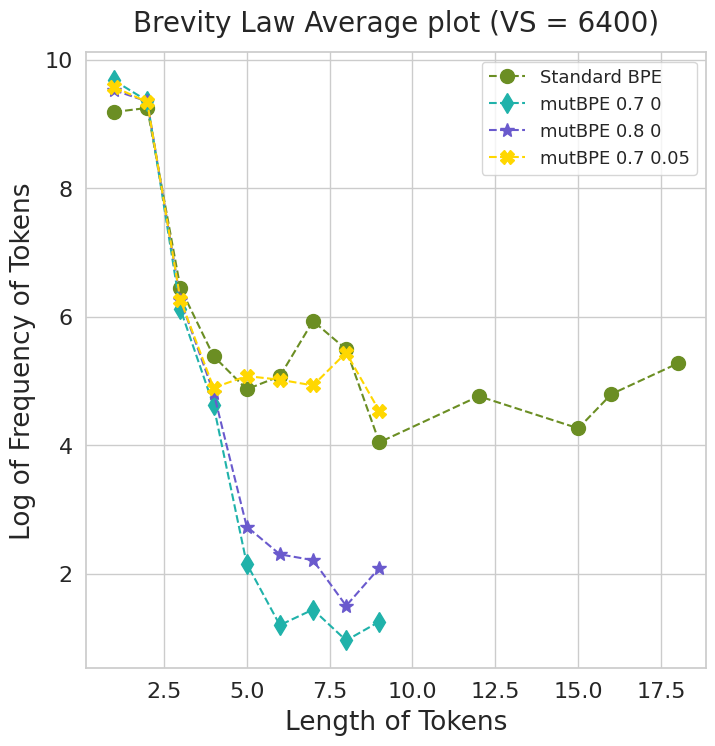

In [35]:
vocab_size = vocab_sizes[3]
for idx, method in enumerate(methods):
    tokenizer_name = f'{method}_{vocab_size}'
    token_freqs = token_freqs_dict[tokenizer_name]

    freqs = np.log(np.array(list(token_freqs.values())))
    lengths = np.array([len(token) for token in list(token_freqs.keys())])

    lf_df = pd.DataFrame([lengths, freqs]).T
    lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
    lf_df['lengths'] = lf_df['lengths'].astype(int)
    lf_mean = lf_df.groupby('lengths')['freqs'].mean()
    lf_mean = lf_mean[lf_mean.index < 20]
    plt.plot(lf_mean.index, lf_mean, markers[idx], color=colors[idx], markersize=10, label=methods2names[method])

plt.title(f"Brevity Law Average plot (VS = {vocab_size})", pad=title_pad)
# plt.ylim(bottom=0, top=11)
# plt.xlim(left=0, right=17)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/brevity_avg_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/brevity_avg_{vocab_size}.png', bbox_inches='tight')
plt.show()

## Heap's Law

Heaps' law states that the growth of vocabulary size increases with dataset size but at a decreasing rate.

In [36]:
np.random.seed(10)
heaps_dict = {}
test_protein_df_permutation = np.random.permutation(len(df_protein))

for tokenizer_name in tqdm(tokenizer_list.keys()):
    tokens_set = set()
    unique_tokens_count = [0]
    all_tokens_count = [0]
    test_df = df_protein.copy()
    test_df_permutation = test_protein_df_permutation.copy()
    for i in test_df_permutation:
        tokens_set = tokens_set.union(test_df[tokenizer_name].iloc[i])
        unique_tokens_count.append(len(tokens_set))
        all_tokens_count.append(all_tokens_count[-1]+len(test_df[tokenizer_name].iloc[i]))
    heaps_dict[tokenizer_name] = (unique_tokens_count, all_tokens_count)

100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


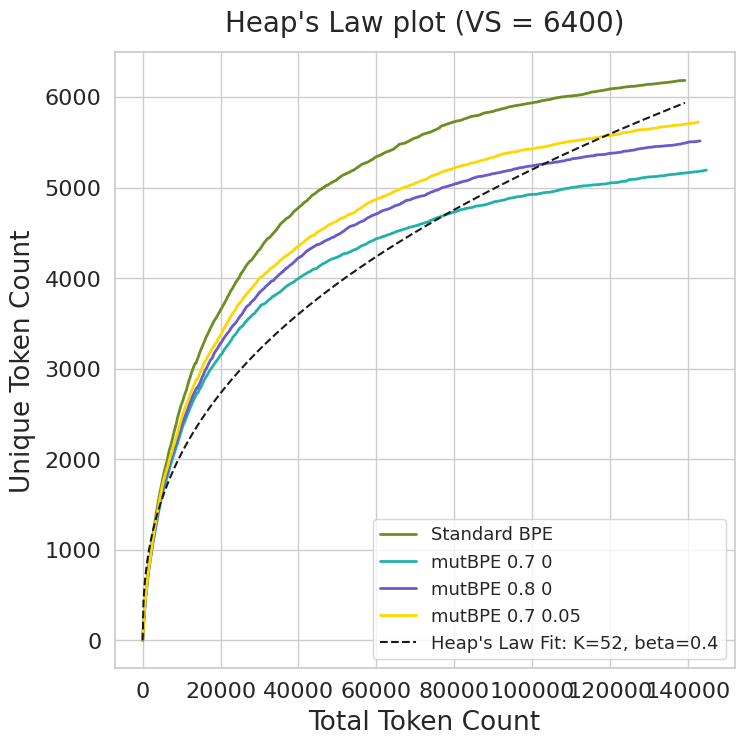

In [37]:
sns.set_style("whitegrid")
vocab_size = vocab_sizes[3]

max_index = 0
for method in methods:
    tokenizer_name = f'{method}_{vocab_size}'
    pareto_max = int(heaps_dict[tokenizer_name][0][-1]*.8)
    for i, cnt in enumerate(heaps_dict[tokenizer_name][0]):
        if cnt >= pareto_max:
            if i > max_index:
                max_index = i
            break

for i, method in enumerate(methods):
    tokenizer_name = f'{method}_{vocab_size}'
    y_data = heaps_dict[tokenizer_name][0][:max_index+vocab_size//50]
    x_data = heaps_dict[tokenizer_name][1][:max_index+vocab_size//50]
    plt.plot(x_data, y_data, '-', linewidth=2, color=colors[i], label=methods2names[method])
    
K = 52
beta = 0.4

x_data = heaps_dict[f'{methods[0]}_{vocab_size}'][1][:max_index+vocab_size//50]
plt.plot(x_data, K*np.array(x_data)**beta, "--k", linewidth=1.5, label=f"Heap's Law Fit: K={K}, beta={beta}")

plt.title(f"Heap's Law plot (VS = {vocab_size})", pad=title_pad)
# plt.xlim([0, 400000])
# plt.ylim([0, 10500])
plt.xlabel("Total Token Count", labelpad=label_pad)
plt.ylabel("Unique Token Count", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/heap_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/heap_{vocab_size}.png', bbox_inches='tight')
plt.show()

## Menzerath's Law

Menzerath's law shows the inverse relationship between a protein sequence's length and its tokens' length.

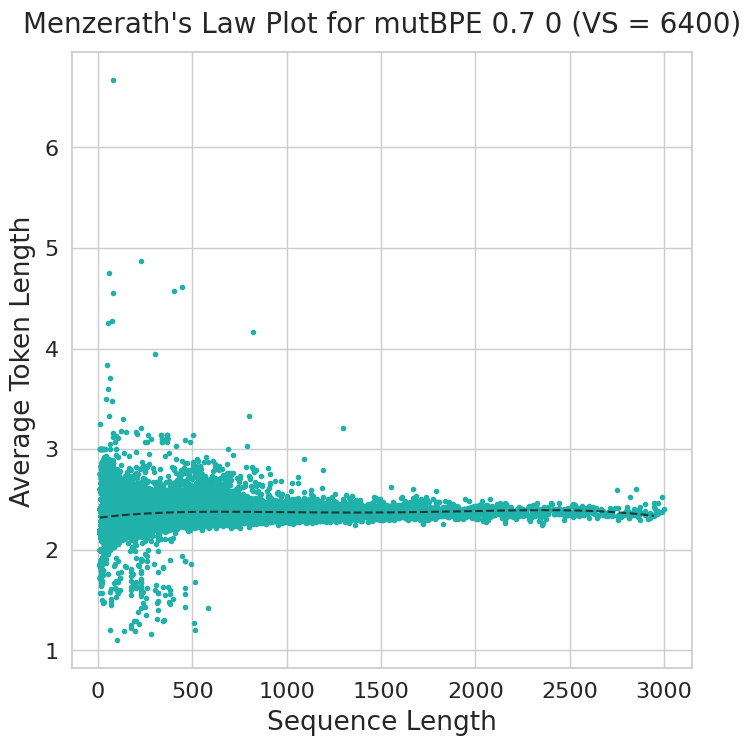

In [38]:
sns.set_style("whitegrid")
vocab_size = vocab_sizes[3]
i = 1
method = methods[i]
    
seq_lengths = df_protein['sequence'].apply(len)
avg_token_lengths = df_protein[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[i], label=f'{method}')

seq_lengths = df_protein['sequence'].apply(len)
avg_token_lengths = df_protein[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
p = np.poly1d(coefficients)
y_fit = p(sorted(list(set(seq_lengths))))
plt.plot(sorted(list(set(seq_lengths)))[:-10], y_fit[:-10], '--k', alpha=.8)

plt.title(f"Menzerath's Law Plot for {methods2names[method]} (VS = {vocab_size})", pad=title_pad)
# plt.xlim([-125, 3125])
# plt.ylim([1.7,3.3])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
# plt.legend()
# plt.savefig(f'{figures_folder_name}/menzerath_{method}_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/menzerath_{method}_{vocab_size}.png', bbox_inches='tight')
plt.show()

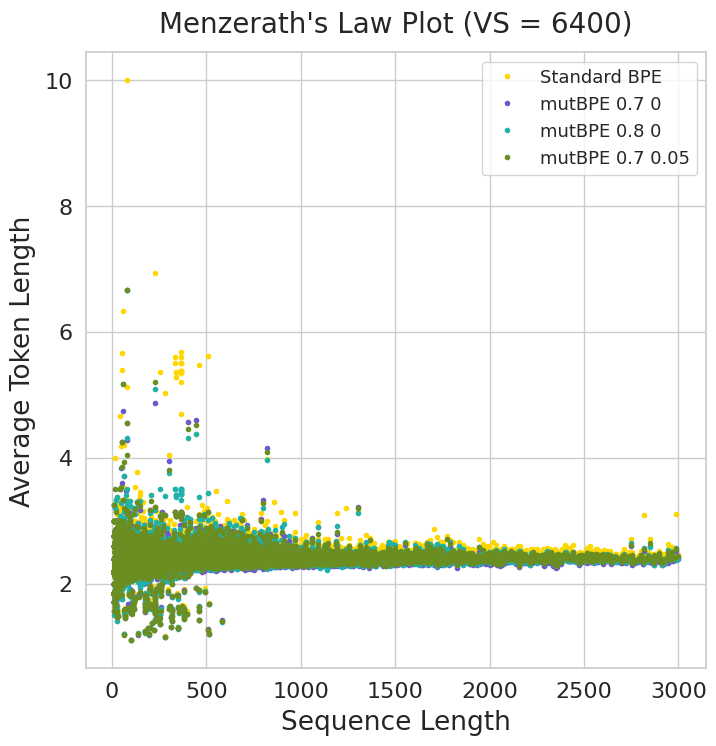

In [39]:
vocab_size = vocab_sizes[3]
for i, method in enumerate(methods):
    seq_lengths = df_protein['sequence'].apply(len)
    avg_token_lengths = df_protein[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[::-1][-4:][i], label=f'{methods2names[method]}')#_{vocab_size}')

    
# for i, method in enumerate(methods[::-1]):
#     seq_lengths = df_protein['sequence'].apply(len)
#     avg_token_lengths = df_protein[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
#     coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
#     p = np.poly1d(coefficients)
#     y_fit = p(sorted(list(set(seq_lengths))))
#     plt.plot(sorted(list(set(seq_lengths))), y_fit, '--k', alpha=.8)


plt.title(f"Menzerath's Law Plot (VS = {vocab_size})", pad=title_pad)
# plt.xlim([0, 2000])
# plt.ylim([1,4])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/menzerath_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/menzerath_{vocab_size}.png', bbox_inches='tight')
plt.show()

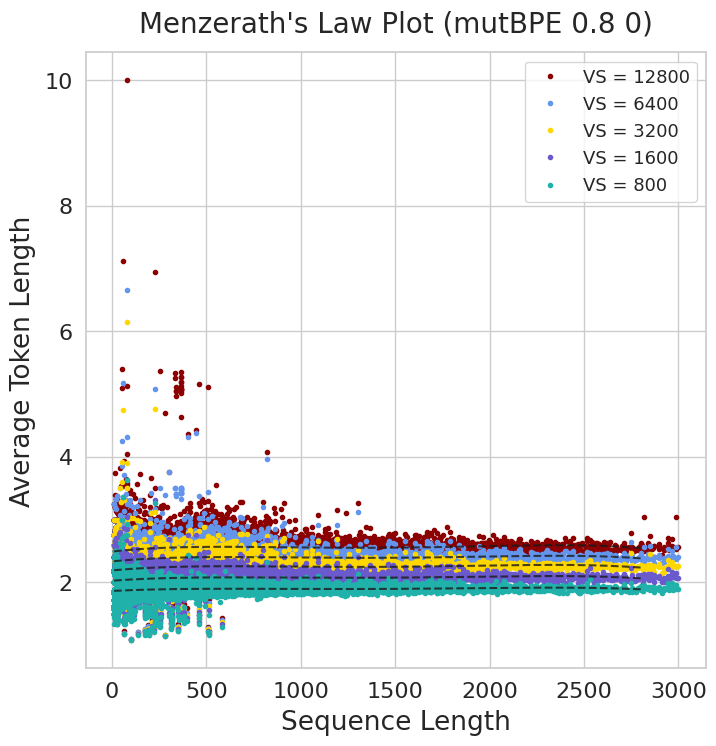

In [40]:
method = methods[-2]
    
for i, vocab_size in enumerate(vocab_sizes[::-1]):
    seq_lengths = df_protein['sequence'].apply(len)
    avg_token_lengths = df_protein[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    plt.plot(seq_lengths, avg_token_lengths, ".", color=colors[::-1][i], label=f'VS = {vocab_size}')


for i, vocab_size in enumerate(vocab_sizes[::-1]):
    seq_lengths = df_protein['sequence'].apply(len)
    avg_token_lengths = df_protein[f'{method}_{vocab_size}'].apply(lambda tokens: np.mean([len(token) for token in tokens]))
    coefficients = np.polyfit(seq_lengths, avg_token_lengths, 4)
    p = np.poly1d(coefficients)
    y_fit = p(sorted(list(set(seq_lengths))))
    plt.plot(sorted(list(set(seq_lengths)))[:-30], y_fit[:-30], '--k', alpha=.8)
    
plt.title(f"Menzerath's Law Plot ({methods2names[method]})", pad=title_pad)
# plt.xlim([0, 2000])
# plt.ylim([1, 4])
plt.xlabel("Sequence Length", labelpad=label_pad)
plt.ylabel("Average Token Length", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/menzerath_{methods2names[method]}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/menzerath_{methods2names[method]}.png', bbox_inches='tight')
plt.show()

## Protein Domain Boundary Alignment

Protein domain boundary alignment during tokenization is essential to preserving the biological meaning of the sequence.

In [13]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_interpro_domain = pd.read_sql(f"SELECT uniprot_id, start_index, end_index FROM interpro_entries_v2 WHERE type='domain'", conn)
df_interpro_domain['source'] = 'interpro'

df_ted = pd.read_sql(f"SELECT uniprot_id, start_index, end_index FROM ted_entries_summary WHERE plddt >= 70", conn)
df_ted['source'] = 'ted'

conn.close()

In [22]:
df_domain_boundaries = pd.concat([df_interpro_domain, df_ted])

In [41]:
df_domain_boundaries = df_protein.iloc[:,:2].set_index('uniprot_id').join(df_domain_boundaries.set_index('uniprot_id'), how='inner').reset_index()

In [50]:
# Find uniprot_ids that have "interpro" as a source
interpro_ids = df_domain_boundaries.loc[df_domain_boundaries["source"] == "interpro", "uniprot_id"].unique()

# Filter the DataFrame to exclude rows with source "ted" for those uniprot_ids
df_domain_boundaries = df_domain_boundaries[~((df_domain_boundaries["uniprot_id"].isin(interpro_ids)) & (df_domain_boundaries["source"] == "ted"))]

df_domain_boundaries

,uniprot_id,sequence,start_index,end_index,source
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,69,152,ted
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,32,333,ted
2,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,344,362,ted
3,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,376,515,ted
4,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,31,69,interpro
...,...,...,...,...,...
192052,X6RL26,MQPMSFGWDHSLHKRKRLPPVKRSLVYYLKNREVRLQNETSYSRVL...,54,189,interpro
192055,X6RL45,MVRCYVEIVEKLPERRPDPATIEGCAQLKPNNYLLAWHTPFNEKGS...,1,161,ted
192056,X6RL83,MLQEWLAAVGDDYAAVVWRPEGEPRFYPDEEGPKHWTKERHQFLME...,2,218,ted
192057,X6RLN4,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,3,54,ted


In [ ]:
tokens_cumsum_df = df_protein.iloc[:,2:].map(lambda tokens: np.cumsum(np.array([len(x) for x in tokens])))
tokens_cumsum_df = pd.concat([df_protein.iloc[:,:1], tokens_cumsum_df], axis=1)
tokens_cumsum_df = pd.merge(df_domain_boundaries, tokens_cumsum_df, 'inner', ['uniprot_id'])
tokens_cumsum_df

,uniprot_id,sequence,start_index,end_index,source,bpe_800,bpe_1600,bpe_3200,bpe_6400,bpe_12800,...,mutbpe_8_0_800,mutbpe_8_0_1600,mutbpe_8_0_3200,mutbpe_8_0_6400,mutbpe_8_0_12800,mutbpe_7_05_800,mutbpe_7_05_1600,mutbpe_7_05_3200,mutbpe_7_05_6400,mutbpe_7_05_12800
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,69,152,ted,"[1, 3, 5, 8, 9, 12, 14, 16, 18, 20, 22, 25, 27...","[3, 5, 8, 9, 12, 14, 16, 18, 20, 22, 25, 27, 2...","[3, 5, 8, 12, 14, 16, 18, 20, 22, 25, 27, 29, ...","[3, 5, 8, 12, 14, 18, 20, 22, 25, 29, 31, 33, ...","[3, 5, 8, 12, 14, 18, 20, 22, 25, 29, 31, 33, ...",...,"[1, 3, 5, 6, 8, 9, 12, 14, 16, 18, 20, 22, 25,...","[1, 3, 5, 8, 9, 12, 14, 16, 18, 20, 22, 25, 27...","[3, 5, 8, 9, 12, 14, 16, 18, 20, 22, 25, 27, 2...","[3, 5, 8, 12, 14, 16, 18, 20, 22, 25, 27, 29, ...","[3, 5, 8, 12, 14, 18, 20, 22, 25, 29, 31, 33, ...","[1, 3, 5, 6, 8, 9, 12, 14, 16, 18, 20, 22, 25,...","[1, 3, 5, 8, 9, 12, 14, 16, 18, 20, 22, 25, 27...","[3, 5, 8, 9, 12, 14, 16, 18, 20, 22, 25, 27, 2...","[3, 5, 8, 12, 14, 16, 18, 20, 22, 25, 27, 29, ...","[3, 5, 8, 12, 16, 18, 22, 25, 27, 29, 31, 33, ..."
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,32,333,ted,"[1, 3, 6, 7, 10, 12, 14, 16, 19, 20, 22, 24, 2...","[3, 6, 7, 10, 12, 14, 16, 19, 20, 22, 24, 26, ...","[3, 6, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, ...","[3, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, 31,...","[3, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, 31,...",...,"[1, 3, 6, 7, 9, 10, 12, 14, 16, 19, 20, 22, 23...","[1, 3, 6, 7, 10, 12, 14, 16, 20, 23, 24, 26, 2...","[3, 6, 7, 10, 12, 14, 16, 20, 23, 24, 26, 28, ...","[3, 6, 7, 10, 12, 14, 16, 20, 23, 26, 28, 31, ...","[3, 7, 10, 12, 14, 16, 20, 23, 26, 28, 31, 33,...","[1, 3, 6, 7, 9, 10, 12, 14, 16, 19, 20, 22, 23...","[1, 3, 6, 7, 9, 12, 14, 16, 20, 23, 24, 26, 28...","[3, 6, 7, 9, 12, 14, 16, 20, 23, 26, 28, 29, 3...","[3, 7, 9, 12, 14, 16, 20, 23, 26, 28, 31, 33, ...","[3, 7, 9, 12, 14, 16, 20, 23, 26, 28, 31, 33, ..."
2,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,344,362,ted,"[1, 3, 6, 7, 10, 12, 14, 16, 19, 20, 22, 24, 2...","[3, 6, 7, 10, 12, 14, 16, 19, 20, 22, 24, 26, ...","[3, 6, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, ...","[3, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, 31,...","[3, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, 31,...",...,"[1, 3, 6, 7, 9, 10, 12, 14, 16, 19, 20, 22, 23...","[1, 3, 6, 7, 10, 12, 14, 16, 20, 23, 24, 26, 2...","[3, 6, 7, 10, 12, 14, 16, 20, 23, 24, 26, 28, ...","[3, 6, 7, 10, 12, 14, 16, 20, 23, 26, 28, 31, ...","[3, 7, 10, 12, 14, 16, 20, 23, 26, 28, 31, 33,...","[1, 3, 6, 7, 9, 10, 12, 14, 16, 19, 20, 22, 23...","[1, 3, 6, 7, 9, 12, 14, 16, 20, 23, 24, 26, 28...","[3, 6, 7, 9, 12, 14, 16, 20, 23, 26, 28, 29, 3...","[3, 7, 9, 12, 14, 16, 20, 23, 26, 28, 31, 33, ...","[3, 7, 9, 12, 14, 16, 20, 23, 26, 28, 31, 33, ..."
3,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,376,515,ted,"[1, 3, 6, 7, 10, 12, 14, 16, 19, 20, 22, 24, 2...","[3, 6, 7, 10, 12, 14, 16, 19, 20, 22, 24, 26, ...","[3, 6, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, ...","[3, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, 31,...","[3, 7, 10, 12, 14, 16, 20, 22, 24, 26, 28, 31,...",...,"[1, 3, 6, 7, 9, 10, 12, 14, 16, 19, 20, 22, 23...","[1, 3, 6, 7, 10, 12, 14, 16, 20, 23, 24, 26, 2...","[3, 6, 7, 10, 12, 14, 16, 20, 23, 24, 26, 28, ...","[3, 6, 7, 10, 12, 14, 16, 20, 23, 26, 28, 31, ...","[3, 7, 10, 12, 14, 16, 20, 23, 26, 28, 31, 33,...","[1, 3, 6, 7, 9, 10, 12, 14, 16, 19, 20, 22, 23...","[1, 3, 6, 7, 9, 12, 14, 16, 20, 23, 24, 26, 28...","[3, 6, 7, 9, 12, 14, 16, 20, 23, 26, 28, 29, 3...","[3, 7, 9, 12, 14, 16, 20, 23, 26, 28, 31, 33, ...","[3, 7, 9, 12, 14, 16, 20, 23, 26, 28, 31, 33, ..."
4,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,31,69,interpro,"[1, 3, 4, 7, 8, 11, 14, 16, 19, 21, 23, 25, 28...","[3, 7, 8, 11, 14, 16, 19, 21, 23, 25, 28, 30, ...","[3, 7, 8, 11, 14, 16, 19, 21, 23, 25, 28, 30, ...","[3, 7, 8, 11, 14, 16, 19, 23, 25, 28, 32, 35, ...","[3, 7, 8, 11, 14, 16

### Boundary Detection

In [ ]:
def domain_boundary_detection(row):
    return {token_col+'_boundary': (True if row['start_index'] == 1 else row['start_index']-1 in row[token_col], row['end_index'] in row[token_col]) for token_col in list(tokenizer_list.keys())}

df_tokens_domain_boundary = pd.DataFrame.from_dict(list(tokens_cumsum_df.apply(domain_boundary_detection, axis=1)))
df_tokens_domain_boundary = pd.concat([tokens_cumsum_df.loc[:, :'source'], df_tokens_domain_boundary], axis=1)
df_tokens_domain_boundary

,uniprot_id,sequence,start_index,end_index,source,bpe_800_boundary,bpe_1600_boundary,bpe_3200_boundary,bpe_6400_boundary,bpe_12800_boundary,...,mutbpe_8_0_800_boundary,mutbpe_8_0_1600_boundary,mutbpe_8_0_3200_boundary,mutbpe_8_0_6400_boundary,mutbpe_8_0_12800_boundary,mutbpe_7_05_800_boundary,mutbpe_7_05_1600_boundary,mutbpe_7_05_3200_boundary,mutbpe_7_05_6400_boundary,mutbpe_7_05_12800_boundary
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,69,152,ted,"(False, False)","(False, False)","(False, False)","(False, False)","(False, False)",...,"(False, False)","(False, False)","(False, False)","(False, False)","(False, False)","(False, False)","(False, False)","(False, False)","(False, False)","(False, False)"
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,32,333,ted,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)",...,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)"
2,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,344,362,ted,"(False, True)","(False, True)","(False, True)","(False, True)","(False, True)",...,"(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)"
3,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,376,515,ted,"(True, True)","(True, True)","(True, True)","(False, True)","(False, True)",...,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(False, True)"
4,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,31,69,interpro,"(True, False)","(True, False)","(True, False)","(False, False)","(False, False)",...,"(True, False)","(True, False)","(True, False)","(True, False)","(False, False)","(True, False)","(True, False)","(True, False)","(False, False)","(False, False)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120455,X6RL26,MQPMSFGWDHSLHKRKRLPPVKRSLVYYLKNREVRLQNETSYSRVL...,54,189,interpro,"(False, True)","(False, True)","(False, True)","(False, True)","(False, True)",...,"(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)"
120456,X6RL45,MVRCYVEIVEKLPERRPDPATIEGCAQLKPNNYLLAWHTPFNEKGS...,1,161,ted,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)",...,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)"
120457,X6RL83,MLQEWLAAVGDDYAAVVWRPEGEPRFYPDEEGPKHWTKERHQFLME...,2,218,ted,"(False, True)","(False, True)","(False, True)","(False, True)","(False, True)",...,"(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)","(False, True)"
120458,X6RLN4,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,3,54,ted,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)",...,"(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)","(True, True)"


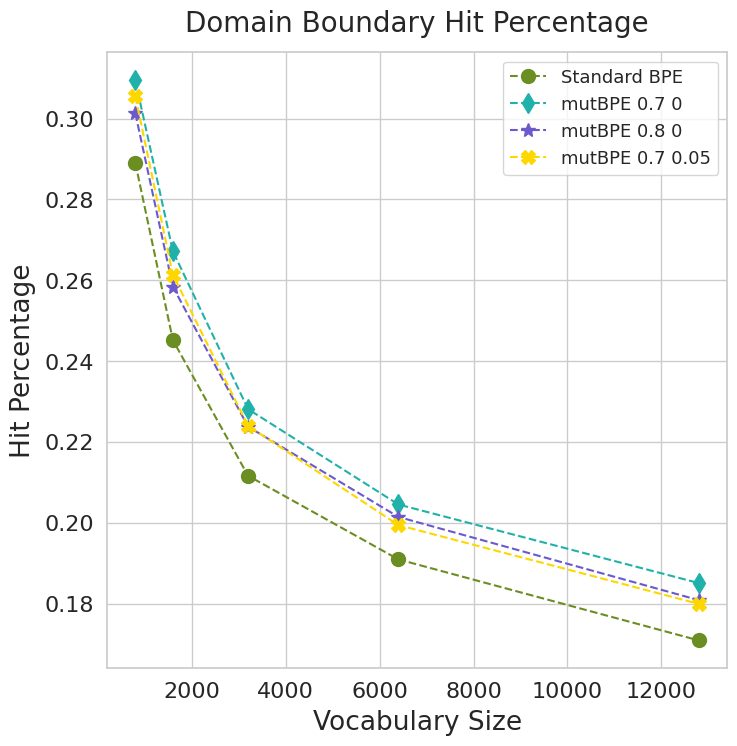

In [96]:
sns.set_style("whitegrid")
for i, method in enumerate(methods):
    # test_df = df_tokens_domain_boundary[df_tokens_domain_boundary['source'] == 'ted']
    test_df = df_tokens_domain_boundary.copy()
    plt.plot(vocab_sizes, [test_df[f'{method}_{vocab_size}_boundary'].value_counts(normalize=True)[(True, True)] for vocab_size in vocab_sizes],
             markers[i],
             color=colors[i],
             markersize=10,
             label=methods2names[method])

plt.title(f"Domain Boundary Hit Percentage", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Hit Percentage", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
# plt.ylim([.1, .4])

# plt.savefig(f'{figures_folder_name}/domain_boundary.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/domain_boundary.png', bbox_inches='tight')

plt.show()